# Machine Learning Course Project
## Identifying User Stance On Social Media via Semi-Supervised Learning

### Overview

#### Midsem Pipeline - 

 - **Read Data**: Read text files to load all the words. 
 - **Clean Data**: Remove stop-words, everything lowercase, dehashify hashtags.
 - **Format Data**: Create data in a format required by each baseline method. 
 - **Baseline Approaches**: LSA, pLSA, Para2Vec, LDA Topic Modelling. The goal of these approaches is to create a "FIXED SIZE" and "HIGH LEVEL" feature representation for variable length tweets. These representations leverage our unlabelled data. 
 - **Training**: Some Supervised Learning on the learned representation using the given labels. 
 - **Evaluation**: Compare the different methods mentioned above on different datasets. 

#### Endsem Approaches - 
 - LDA2Vec - https://www.datacamp.com/community/tutorials/lda2vec-topic-model
 - Gaussian LDA - https://rajarshd.github.io/papers/acl2015.pdf
 - Word Embeddings Informed Topic Models - http://proceedings.mlr.press/v77/zhao17a/zhao17a.pdf
 
#### Reference
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Constants

In [1]:
# PATH_LABELLED_DATA_TRAINING = "../semeval2016-task6-domaincorpus/data-all-annotations/trainingdata-all-annotations.txt"
PATH_LABELLED_DATA_TRUMP = "../semeval2016-task6-domaincorpus/data-all-annotations/testdata-taskB-all-annotations.txt"
PATH_UNLABELLED_DATA_TRUMP = "./../semeval2016-task6-domaincorpus/downloaded_Donald_Trump.txt"

## Data 

In [2]:
# SETUP
# # Run in python console
# import nltk; nltk.download('stopwords')

# # Run in terminal or command prompt
# !python -m spacy download en

In [3]:
# !pip install gensim
# !pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['via'])

### Read Sem-Eval Task A Data (Labelled)

Interactive Visualization - http://www.saifmohammad.com/WebPages/StanceDataset.htm

Targets - 
 - Hilary Clinton
 - Atheism
 - Climate Change
 - Donald Trump
 - Feminism
 - Abortion

### Remove Symbols

In [6]:
def clean_tweets(sent):
    sent = str(sent)
    
    # Remove new line characters
    sent = re.sub('\s+', ' ', sent)

    # Remove distracting single quotes
    sent = re.sub("\'", "", sent)

    # Remove distracting single quotes
    sent = re.sub("\"", "", sent)

    # Remove hashtags
    sent = re.sub("\#", "", sent)

    # Remove http:// links
    sent = re.sub('http:\/\/.*','', sent)

    # Remove https:// links
    sent = re.sub('https:\/\/.*','', sent)
    
    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    sent = emoji_pattern.sub(r'', sent)
    
    return sent
    

In [7]:
data_labelled = pd.read_csv(PATH_LABELLED_DATA_TRUMP, sep='\t', lineterminator='\r', encoding ='latin1')
data_labelled = data_labelled.where(data_labelled.Tweet != 'Not Available')
data_labelled.dropna(how='any', inplace=True)

# data_labelled = data_labelled.where(data_labelled.Target != np.nan)

In [8]:
data_labelled['Tweet'] = data_labelled['Tweet'].apply(clean_tweets)

#### Data Stats

In [9]:
data_labelled.count()

ID                 707
Target             707
Tweet              707
Stance             707
Opinion towards    707
Sentiment          707
dtype: int64

In [10]:
data_labelled

,ID,Target,Tweet,Stance,Opinion towards,Sentiment
0,\n20001,Donald Trump,@2014voteblue @ChrisJZullo blindly supporting ...,NONE,OTHER,NEGATIVE
1,\n20002,Donald Trump,@ThePimpernelX @Cameron_Gray @CalebHowe Totall...,NONE,OTHER,POSITIVE
2,\n20003,Donald Trump,@JeffYoung @ThePatriot143 I fully support full...,NONE,OTHER,POSITIVE
3,\n20004,Donald Trump,@ABC Stupid is as stupid does! Showedhis true ...,AGAINST,TARGET,NEGATIVE
4,\n20005,Donald Trump,@HouseGOP we now have one political party. The...,NONE,OTHER,NEGATIVE
5,\n20006,Donald Trump,Donald Trump isnt afraid to roast everyone. SemST,FAVOR,TARGET,POSITIVE
6,\n20007,Donald Trump,Donald Trump for president? I can dig it. SemST,FAVOR,TARGET,POSITIVE
7,\n20008,Donald Trump,nothing about obamacare changed today what cha...,NONE,OTHER,NEGATIVE
8,\n20009,Donald Trump,"I have one friend, he said he has more account...",NONE,NO ONE,NEITHER
9,\n20010,Donald Trump,After today SCOTUS has passed more legislation...,NONE,OTHER,NEITHER


data_labelled.where(data_labelled.Stance == 'AGAINST').count()

data_labelled.where(data_labelled.Stance == 'NONE').count()

data_labelled.where(data_labelled.Stance == 'FAVOR').count()

### Read Sem-Eval Task B Data (Unlabelled)

In [11]:
data_unlabelled = pd.read_csv(PATH_UNLABELLED_DATA_TRUMP, sep='\t', lineterminator='\n', encoding ='latin1', names = ["ID", "Tweet"])
data_unlabelled = data_unlabelled.where(data_unlabelled.Tweet != 'Not Available')
data_unlabelled.dropna(how='any', inplace=True)
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(lambda x: x[1:])
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(clean_tweets)
# data_unlabelled = data_unlabelled[:1000]
# data_unlabelled['Tweet'] = data_unlabelled['Tweet'].str.decode('latin1')

In [12]:
combined_data = pd.concat([data_unlabelled, data_labelled], ignore_index=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [13]:
combined_data.count()

ID                 54323
Opinion towards      707
Sentiment            707
Stance               707
Target               707
Tweet              54323
dtype: int64

In [14]:
combined_data.head(10)

,ID,Opinion towards,Sentiment,Stance,Target,Tweet
0,5.88511e+17,NaN,NaN,NaN,NaN,Dear DonaldTrump: Do you want to see HillaryCl...
1,5.88804e+17,NaN,NaN,NaN,NaN,Trump compares JebBush to liberal U.S. Preside...
2,5.89152e+17,NaN,NaN,NaN,NaN,Trump Lets His Followers Know HillaryClinton C...
3,5.8916e+17,NaN,NaN,NaN,NaN,"Donald Trump blows his trumpet once again, but..."
4,5.89188e+17,NaN,NaN,NaN,NaN,DonaldTrump spreads the message that HillaryCl...
5,5.89191e+17,NaN,NaN,NaN,NaN,Trump Lets His Followers Know HillaryClinton C...
6,5.8931e+17,NaN,NaN,NaN,NaN,Why we need feminism. everydaysexism DonaldTru...
7,5.89317e+17,NaN,NaN,NaN,NaN,DonaldTrump has to be the lowest form of scumb...
8,5.89345e+17,NaN,NaN,NaN,NaN,"Wow, this is a low and disgusting tweet! @real..."
9,5.89371e+17,NaN,NaN,NaN,NaN,\xe2\x80\x9c@Kon__K: Why we need feminism. eve...


In [15]:
df = combined_data['Tweet']
# df = data_labelled['Tweet']

In [16]:
data = df.values.tolist()
pprint(data[:1])

['Dear DonaldTrump: Do you want to see HillaryClinton s birth certificate too? '
 'If so, PLEASE FUCK OFF! UniteBlue LibCrib Hillary2016']


### Sentences To Words

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['dear',
  'donaldtrump',
  'do',
  'you',
  'want',
  'to',
  'see',
  'hillaryclinton',
  'birth',
  'certificate',
  'too',
  'if',
  'so',
  'please',
  'fuck',
  'off',
  'uniteblue',
  'libcrib',
  'hillary']]


### Create Bi-Grams Tri-Grams

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['dear', 'donaldtrump', 'do', 'you', 'want', 'to', 'see', 'hillaryclinton', 'birth_certificate', 'too', 'if', 'so', 'please', 'fuck', 'off', 'uniteblue_libcrib', 'hillary']


### Remove Stop Words and Lemmatize

WE NEED PRONOUNS FOR STANCE

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON'])

print(data_lemmatized[:1]), print(len(data_lemmatized))

[['dear', 'donaldtrump', 'want', 'see', 'hillaryclinton', 'birth_certificate', 'fuck', 'uniteblue_libcrib', 'hillary']]
54323


(None, None)

## Format Data

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [22]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('birth_certificate', 1),
  ('dear', 1),
  ('donaldtrump', 1),
  ('fuck', 1),
  ('hillary', 1),
  ('hillaryclinton', 1),
  ('see', 1),
  ('uniteblue_libcrib', 1),
  ('want', 1)]]

In [23]:
len(id2word)

31331

### Para2Vec Model
Need to train fresh on our data

In [24]:
## TODO:

## LSA

In [53]:
# LSA Model
number_of_topics = 50
number_of_words = 20
lsamodel = LsiModel(corpus, num_topics=number_of_topics, id2word=id2word)  # train model
pprint(lsamodel.print_topics(num_topics=number_of_topics, num_words=number_of_words))
coherencemodel = CoherenceModel(model=lsamodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
pprint(coherencemodel.get_coherence())

[(0,
  '0.826*"trump" + 0.396*"donaldtrump" + 0.174*"realdonaldtrump" + '
  '0.147*"-PRON-" + 0.105*"not" + 0.084*"xf" + 0.079*"amp" + 0.069*"say" + '
  '0.065*"be" + 0.061*"get" + 0.061*"gop" + 0.061*"do" + 0.052*"s" + '
  '0.050*"make" + 0.048*"nbc" + 0.048*"mexican" + 0.048*"go" + 0.044*"vote" + '
  '0.044*"xe" + 0.044*"donald"'),
 (1,
  '0.843*"donaldtrump" + -0.483*"trump" + 0.081*"-PRON-" + 0.067*"not" + '
  '-0.060*"realdonaldtrump" + 0.059*"say" + 0.056*"xf" + 0.053*"mexican" + '
  '0.052*"nbc" + 0.051*"amp" + 0.043*"be" + 0.042*"xe" + 0.040*"do" + '
  '0.038*"fire" + 0.036*"s" + 0.033*"gop" + 0.032*"get" + 0.029*"racist" + '
  '0.027*"comment" + 0.025*"go"'),
 (2,
  '-0.817*"xf" + -0.409*"xba" + -0.388*"xb" + 0.093*"donaldtrump" + '
  '0.055*"trump" + 0.020*"-PRON-" + 0.016*"not" + -0.015*"xbc" + -0.015*"xbd" '
  '+ 0.013*"say" + 0.011*"amp" + 0.011*"gop" + 0.010*"do" + 0.010*"nbc" + '
  '0.007*"s" + 0.007*"be" + 0.007*"get" + 0.007*"mexican" + -0.007*"america" + '
  '-0.006*"

0.2949905360605171


In [ ]:
from gensim.test.utils import get_tmpfile

tmp_fname = get_tmpfile("lsi-model-only-labelled.model")
lsamodel.save(tmp_fname)  # save model

In [ ]:
from gensim.test.utils import get_tmpfile

tmp_fname = get_tmpfile("lsi-model-only-labelled.model")
lsamodel = LsiModel.load(tmp_fname)  # load model

In [54]:
from gensim.test.utils import get_tmpfile

tmp_fname = get_tmpfile("lsi-model.model")
lsamodel.save(tmp_fname)  # save model

In [55]:
from gensim.test.utils import get_tmpfile

tmp_fname = get_tmpfile("lsi-model.model")
lsamodel = LsiModel.load(tmp_fname)  # load model

In [56]:
lsa_feats = lsamodel[corpus][-707:]
lsa_feats = gensim.matutils.corpus2csc(lsa_feats)
lsa_feats = lsa_feats.T.toarray()
lsa_feats.shape

(707, 50)

## Evaluation

### Clean Data

### Format Labelled Data

In [63]:
labelled_corpus = corpus[-707:]
len(labelled_corpus)

707

### Create Dataset for Supervised Learning

In [74]:
mallet_feats = []

for i in range(len(labelled_corpus)):
    representation = ldamallet.get_document_topics(labelled_corpus[i])
    count = 0
    feat = []
    for i in range(50):
        if i in list(map((lambda x: x[0]), representation)):
            feat.append(representation[count][1])
            count = count + 1
        else:
            feat.append(0)
    mallet_feats.append(feat)

In [75]:
STANCES = ['AGAINST', 'FAVOR', 'NONE']

In [76]:
def transform_labels(label):
    if label == 'AGAINST':
        return 0
    elif label == 'FAVOR':
        return 1
    elif label == 'NONE':
        return 2

In [77]:
# labelled_stance = combined_data.Stance[53616:54323]
labelled_stance = data_labelled['Stance']
labelled_stance = labelled_stance.apply(transform_labels)
labelled_stance = labelled_stance.tolist()

In [78]:
len(mallet_feats[0]), len(mallet_feats)

(50, 707)

## Supervised Learning

In [79]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
import argparse
from sklearn.utils.multiclass import unique_labels

In [80]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [81]:
def RandomForest(feats, labelled_stance):
    # feats = list(map((lambda x: np.array(x)), feats))
    X = np.array(feats)
    Y = np.array(labelled_stance)
    
    rlf = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


    rf_cv = cross_val_score(rlf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["RF_cross_val_score"] = rf_cv.tolist()
    report["RF_mean_acc"] = rf_cv.mean()
    report["RF_std_acc"] = rf_cv.std()*2
    
#     for i in range(1,10):
#         print(i)
#         X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=i/10.0, random_state=0)

    rlf.fit(X_train, y_train)
    y_pred = rlf.predict(X_test)

    rf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')
#         report["RF_CM"+str(i)] = rf_cm.tolist()
    report["RF_CM"] = rf_cm.tolist()

    
    return report

In [82]:
def SVMClassifier(feats, labelled_stance):
    X = np.array(feats)
    Y = np.array(labelled_stance)
    
    clf = svm.SVC(gamma='auto', C=300, kernel='linear')
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    clf_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["SVM_cross_val_score"] = clf_cv.tolist()
    report["SVM_mean_acc"] = clf_cv.mean()
    report["SVM_std_acc"] = clf_cv.std()*2
    
#   for i in range(1,10):
#          print(i)
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=i/10.0, random_state=0)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    clf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')
#     report["SVM_CM"+str(i)] = clf_cm.tolist()
    report["SVM_CM"] = clf_cm.tolist()

    
    return report
    

Confusion matrix, without normalization
[[61  4 27]
 [19 15  3]
 [36  2 46]]
{'SVM_cross_val_score': [0.5383408102509226, 0.4372947109789216, 0.4258384055376537, 0.4742075129171903, 0.511511789181692], 'SVM_mean_acc': 0.477438645773276, 'SVM_std_acc': 0.08557856391631632, 'SVM_CM': [[61, 4, 27], [19, 15, 3], [36, 2, 46]]}


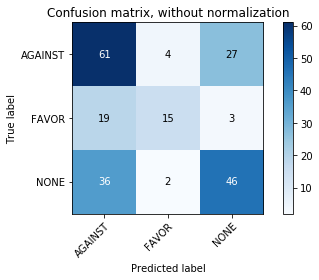

In [83]:
mallet_report = SVMClassifier(mallet_feats, labelled_stance)
print(mallet_report)

Confusion matrix, without normalization
[[43 18 31]
 [10 25  2]
 [18  2 64]]
{'SVM_cross_val_score': [0.632957957957958, 0.5258303742181276, 0.6219103313840156, 0.5586544709351727, 0.66130051897264], 'SVM_mean_acc': 0.6001307306935828, 'SVM_std_acc': 0.10013808046945234, 'SVM_CM': [[43, 18, 31], [10, 25, 2], [18, 2, 64]]}


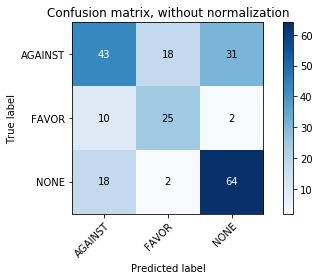

In [84]:
lsa_report = SVMClassifier(lsa_feats, labelled_stance)
print(lsa_report)

Confusion matrix, without normalization
[[50 12 30]
 [16 19  2]
 [26  1 57]]
{'RF_cross_val_score': [0.7246748335801086, 0.5709810059125128, 0.5772357723577236, 0.6086438923395444, 0.5594084005939517], 'RF_mean_acc': 0.6081887809567682, 'RF_std_acc': 0.12096690574055656, 'RF_CM': [[50, 12, 30], [16, 19, 2], [26, 1, 57]]}


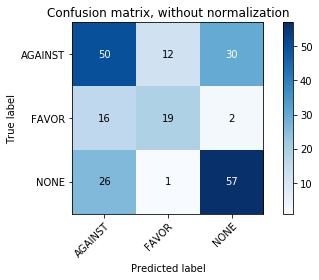

In [85]:
mallet_report = RandomForest(mallet_feats, labelled_stance)
print(mallet_report)

Confusion matrix, without normalization
[[52 15 25]
 [11 24  2]
 [24  1 59]]
{'RF_cross_val_score': [0.549719014835294, 0.5422717550377124, 0.5781119465329992, 0.5492594941168182, 0.6536138966518713], 'RF_mean_acc': 0.574595221434939, 'RF_std_acc': 0.08276158336771182, 'RF_CM': [[52, 15, 25], [11, 24, 2], [24, 1, 59]]}


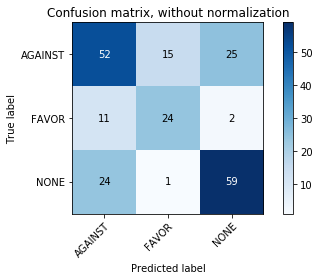

In [86]:
lsa_report = RandomForest(lsa_feats, labelled_stance)
print(lsa_report)